In [1]:
from src.foundation.engine import Engine
from src.data_handler.data_handler import DataHandler
from src.explainability.pdp import PDP
from datetime import datetime
import ipdb

Define hyper-parameters for DS data:

In [2]:
hyperparam_dict_ds_data = {
        'states': ['lead_time', 'length_of_stay',
                   'competitor_price_difference_bin', 'demand_bin'],
        'actions': ['price'],
        'bins': [10, 10, 4, 4, 10], #TODO: these correspond to the states and actions. Probably should change to a dict.
        'rewards': ['reward'],
        'feature_types': {
            'lead_time': "continuous",
            'length_of_stay': "continuous",
            'competitor_price_difference_bin': "discrete",
            'demand_bin': "discrete",
            'price': "continuous",
            'reward': "continuous"
        },
        'n_samples': 100000,
        'data_path': 'data/ds-data/my_example_data.parquet',
        'col_delimiter': '|',
        'cols_to_normalise': ['lead_time', 'length_of_stay',
                   'competitor_price_difference_bin', 'demand_bin', 'price', 'reward'],
        'agent_type': 'q_learner',
        'env_type': 'strategic_pricing',
        'num_episodes': 50000,
        'num_steps': 1,
        'train_test_split': 0.2
    }

hyperparam_dict = hyperparam_dict_ds_data

Train agent (I interrupted at 50,000 episodes because it was taking too long):

In [3]:
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Load data")
states = hyperparam_dict['states']
actions = hyperparam_dict['actions']
rewards = hyperparam_dict['rewards']
n_samples = hyperparam_dict['n_samples']
dh = DataHandler(data_path=hyperparam_dict['data_path'],
                    state_labels=states,
                    action_labels=actions,
                    reward_labels=rewards,
                    n_samples=n_samples)

# Preprocess the data
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Preprocess data")
dh.prepare_data_for_engine(col_delimiter=hyperparam_dict['col_delimiter'],
                            cols_to_normalise=hyperparam_dict[
                                'cols_to_normalise'])

# Create engine
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

print(f"{timestamp}: Initialize Engine")
engine = Engine(dh,
                agent_type=hyperparam_dict['agent_type'],
                env_type=hyperparam_dict['env_type'],
                num_episodes=hyperparam_dict['num_episodes'],
                num_steps=hyperparam_dict['num_steps'],
                bins=hyperparam_dict['bins'],
                train_test_split = hyperparam_dict['train_test_split']
                )
# Create world
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Create the world")
engine.create_world()

# Train agent
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Train the agent on {n_samples} samples")
engine.train_agent(evaluate=True, n_eval_steps=1000)

14/04/2023 08:26:19: Load data
14/04/2023 08:26:19: Preprocess data
14/04/2023 08:26:21: Initialize Engine
14/04/2023 08:26:21: Create the world
Initialize environment
Create average rewards matrix
Initialize agent
14/04/2023 08:26:37: Train the agent on 100000 samples


100%|██████████| 1000/1000 [00:05<00:00, 166.84it/s]


Evaluate agent (get evaluation states, actions, rewards, and recommended actions and resulting rewards):

In [4]:
states, actions_hist, b_actions, rewards_hist, actions_agent, b_actions_agent, rewards_agent = \
    engine.evaluate_agent()

# Sum obtained reward optimal vs historical policy
import numpy as np
print(f"Return based on historical data: {np.sum(rewards_hist)}")
print(f"Return based on agent policy: {np.sum(rewards_agent)}")

Return based on historical data: 147642.84877104228
Return based on agent policy: 135756.98058590954


Get plot of cumulative reward vs iteration:

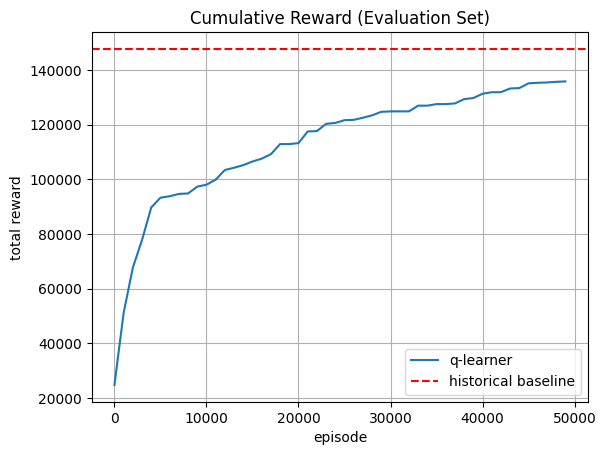

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
axes.plot([i*1000 for i in range(len(engine.agent_cumrewards))], engine.agent_cumrewards, label='q-learner')
axes.axhline(np.sum(rewards_hist), color='r',linestyle='--', label='historical baseline')
axes.grid()
axes.set_xlabel("episode")
axes.set_ylabel("total reward")
axes.legend()
axes.set_title("Cumulative Reward (Evaluation Set)")
plt.savefig("cumulative_reward.png")


Get plot of reward percentiles:

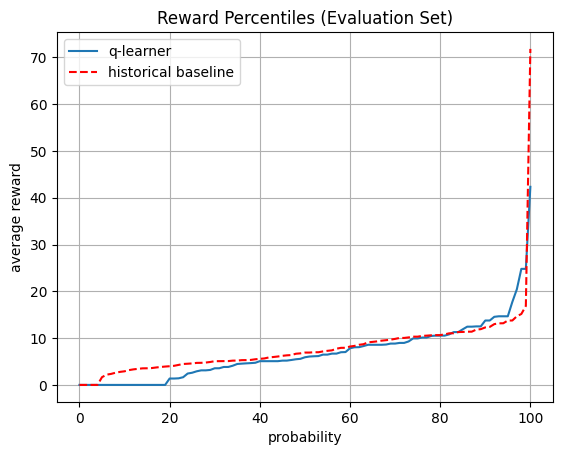

In [9]:
rewards_agent_array = np.array([r[0] for r in rewards_agent])
agent_percentiles = np.percentile(rewards_agent_array, q=np.linspace(0,100,101))

rewards_hist_array = np.array([r[0] for r in rewards_hist])
hist_percentiles = np.percentile(rewards_hist_array, q=np.linspace(0,100,101))

fig, axes = plt.subplots()
axes.plot(np.linspace(0,100,101), agent_percentiles, label='q-learner')
axes.plot(np.linspace(0,100,101), hist_percentiles, color='r',linestyle='--', label='historical baseline')

axes.grid()
axes.set_xlabel("probability")
axes.set_ylabel("average reward")
axes.legend()
axes.set_title("Reward Percentiles (Evaluation Set)")
plt.savefig("reward_percentiles.png")

Compare actions:

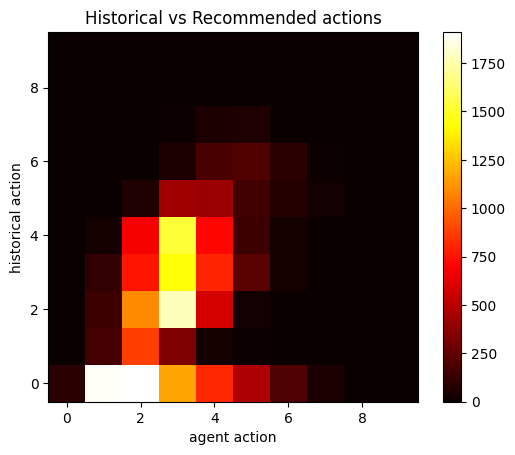

In [19]:
count_actions = np.zeros(shape=(10,10))
for a, h in zip(b_actions_agent, b_actions):
    count_actions[a,h] += 1
plt.imshow(count_actions, cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('agent action')
plt.ylabel('historical action')
plt.title('Historical vs Recommended actions')
plt.colorbar()

PDP plots:

In [16]:
# Plot PDPs
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Show PDPs plots")
pdp = PDP(bins=engine.env.bins,
            minmax_scalars=dh.minmax_scalars,
            action_labels=actions,
            state_labels=states)
pdp.build_data_for_plots(engine.agent.Q, engine.agent.Q_num_samples)
type_features = hyperparam_dict['feature_types']
fig_name = "PDP plots - All states"
pdp.plot_pdp(states_names=states, fig_name=fig_name,
                type_features=type_features, savefig=True, all_states=True)
fig_name = "PDP plots - Visited states"
pdp.plot_pdp(states_names=states, fig_name=fig_name,
                type_features=type_features, savefig=True, all_states=False)



14/04/2023 10:03:04: Show PDPs plots


TypeError: unhashable type: 'list'

In [58]:
b_actions = engine.env.bin_states(actions, idxs=list(range(engine.env.state_dim, engine.env.state_dim+engine.env.action_dim)))

In [10]:
b_actions

[[6],
 [3],
 [1],
 [3],
 [3],
 [3],
 [2],
 [4],
 [3],
 [3],
 [2],
 [4],
 [1],
 [2],
 [3],
 [3],
 [2],
 [2],
 [2],
 [2],
 [3],
 [3],
 [4],
 [3],
 [2],
 [3],
 [3],
 [3],
 [1],
 [1],
 [3],
 [1],
 [2],
 [1],
 [3],
 [3],
 [3],
 [4],
 [1],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [4],
 [4],
 [4],
 [2],
 [5],
 [2],
 [4],
 [4],
 [2],
 [2],
 [3],
 [4],
 [1],
 [5],
 [4],
 [4],
 [4],
 [2],
 [1],
 [7],
 [3],
 [4],
 [2],
 [1],
 [5],
 [3],
 [3],
 [5],
 [3],
 [2],
 [3],
 [1],
 [3],
 [2],
 [1],
 [2],
 [5],
 [2],
 [2],
 [5],
 [2],
 [2],
 [2],
 [3],
 [1],
 [3],
 [1],
 [6],
 [1],
 [3],
 [2],
 [1],
 [3],
 [3],
 [3],
 [3],
 [6],
 [3],
 [2],
 [3],
 [1],
 [2],
 [4],
 [2],
 [2],
 [3],
 [3],
 [3],
 [3],
 [3],
 [2],
 [3],
 [3],
 [2],
 [2],
 [2],
 [3],
 [3],
 [2],
 [4],
 [6],
 [6],
 [2],
 [1],
 [3],
 [3],
 [5],
 [5],
 [1],
 [2],
 [2],
 [2],
 [3],
 [3],
 [2],
 [4],
 [6],
 [6],
 [1],
 [1],
 [3],
 [3],
 [3],
 [2],
 [2],
 [4],
 [3],
 [4],
 [5],
 [4],
 [3],
 [4],
 [6],
 [2],
 [5],
 [2],
 [2],
 [2],
 [3],
 [3],
 [5],
 [1]

In [11]:
list(zip(b_actions, b_actions_agent))

[([6], [4]),
 ([3], [0]),
 ([1], [2]),
 ([3], [0]),
 ([3], [6]),
 ([3], [1]),
 ([2], [2]),
 ([4], [3]),
 ([3], [3]),
 ([3], [3]),
 ([2], [4]),
 ([4], [3]),
 ([1], [0]),
 ([2], [0]),
 ([3], [2]),
 ([3], [2]),
 ([2], [0]),
 ([2], [4]),
 ([2], [1]),
 ([2], [0]),
 ([3], [2]),
 ([3], [3]),
 ([4], [0]),
 ([3], [3]),
 ([2], [0]),
 ([3], [0]),
 ([3], [4]),
 ([3], [0]),
 ([1], [0]),
 ([1], [0]),
 ([3], [0]),
 ([1], [0]),
 ([2], [0]),
 ([1], [0]),
 ([3], [5]),
 ([3], [0]),
 ([3], [4]),
 ([4], [4]),
 ([1], [0]),
 ([3], [3]),
 ([3], [3]),
 ([3], [5]),
 ([3], [4]),
 ([3], [2]),
 ([3], [4]),
 ([4], [3]),
 ([4], [6]),
 ([4], [2]),
 ([2], [0]),
 ([5], [3]),
 ([2], [1]),
 ([4], [0]),
 ([4], [4]),
 ([2], [2]),
 ([2], [0]),
 ([3], [2]),
 ([4], [5]),
 ([1], [1]),
 ([5], [6]),
 ([4], [5]),
 ([4], [2]),
 ([4], [3]),
 ([2], [0]),
 ([1], [0]),
 ([7], [0]),
 ([3], [3]),
 ([4], [4]),
 ([2], [0]),
 ([1], [0]),
 ([5], [5]),
 ([3], [0]),
 ([3], [0]),
 ([5], [6]),
 ([3], [2]),
 ([2], [1]),
 ([3], [4]),
 ([1], [2]),

In [64]:
list(zip(actions, actions_agent))


[([63.599999999999994], [63.94999999999999]), ([81.0], [18.05]), ([68.99999999999999], [94.55]), ([73.8], [109.85]), ([56.6], [63.94999999999999]), ([58.99999999999999], [63.94999999999999]), ([64.99999999999999], [79.25]), ([62.8], [18.05]), ([35.0], [18.05]), ([81.0], [18.05]), ([46.6], [48.65]), ([56.6], [63.94999999999999]), ([28.0], [18.05]), ([63.199999999999996], [79.25]), ([55.2], [63.94999999999999]), ([79.59999999999998], [79.25]), ([67.6], [79.25]), ([82.20000000000002], [18.05]), ([47.6], [63.94999999999999]), ([77.6], [109.85]), ([73.0], [18.05]), ([66.59999999999998], [79.25]), ([75.2], [18.05]), ([51.400000000000006], [33.35]), ([70.4], [79.25]), ([68.0], [18.05]), ([30.4], [18.05]), ([48.6], [63.94999999999999]), ([43.20000000000001], [18.05]), ([31.0], [18.05]), ([70.4], [79.25]), ([48.8], [33.35]), ([47.2], [33.35]), ([54.199999999999996], [48.65]), ([41.0], [63.94999999999999]), ([66.0], [63.94999999999999]), ([79.0], [94.55]), ([32.8], [18.05]), ([51.400000000000006